In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import pdfplumber
import regex as re
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import nltk
import requests
from io import BytesIO
import imblearn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet') 
import re
import contractions
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup 
pd.set_option('display.max_colwidth', None) 
import requests
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from gensim.models import Word2Vec
wv = api.load('word2vec-google-news-300')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [149]:
from PyPDF2 import PdfReader

reader = PdfReader("DCISC-24th-Annual-Report.pdf")
text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"

In [150]:
text

'Developed by Virtual Silk®24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014\nPreface  | Executive Summary\nVolume 1 TOC  | Volume 2 TOC  | PG&E Response  | Contact the DCISC\nDiablo Canyon Independent Safety Committee\nTwenty-fourth Annual Report on the Safety of Diablo Canyon Nuclear Power Plant\nOperations\nJuly 1, 2013 – June 30, 2014\nPeter Lam, Chair\nRobert K Budnitz, Vice-Chair\nPer F. Peterson, Member\n24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014\nPreface  | Executive Summary\nVolume 1 TOC  | Volume 2 TOC  | PG&E Response  | Contact the DCISC\n24th Annual Report , Preface\nThis report covers the activities of the Diablo Canyon Independent Safety Committee (DCISC)\nfor the period July 1, 2013 through June 30, 2014. This is the twenty-fourth annual report of the\nDCISC. The report is presented in two volumes.\nVolume I  includes a report summary and Conclusions and Recommendati

In [152]:
# tokenize the df based on where sentences end. 
from nltk import tokenize
text_to_tokenize = text
tokenized_text = tokenize.sent_tokenize(text_to_tokenize)

In [153]:
len(tokenized_text)

10688

In [154]:
# make a dataframe of the tokenized sentences above and make the text in lower case
df = pd.DataFrame (tokenized_text, columns = ['text'])
df['text'] = df['text'].apply(lambda x:x.lower())
df.head()

text
0              developed by virtual silk®24th annual report by the diablo canyon independent safety committee, july 1, 2013 - june 30, 2014\npreface  | executive summary\nvolume 1 toc  | volume 2 toc  | pg&e response  | contact the dcisc\ndiablo canyon independent safety committee\ntwenty-fourth annual report on the safety of diablo canyon nuclear power plant\noperations\njuly 1, 2013 – june 30, 2014\npeter lam, chair\nrobert k budnitz, vice-chair\nper f. peterson, member\n24th annual report by the diablo canyon independent safety committee, july 1, 2013 - june 30, 2014\npreface  | executive summary\nvolume 1 toc  | volume 2 toc  | pg&e response  | contact the dcisc\n24th annual report , preface\nthis report covers the activities of the diablo canyon independent safety committee (dcisc)\nfor the period july 1, 2013 through june 30, 2014.
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          this is the twenty-fourth annual report of the\ndcisc.
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         the report is presented in two volumes.
3  volume i  includes a report summary and conclusions and recommendation ( executive summary ), a\nbrief introduction and history regarding the dcisc, committee activities, and documents receivedby the dcisc during the reporting period \n(section 1.0 ), dcisc public meetings ( section 2.0 ), a\nreview and evaluation of nuclear regulatory commission (nrc) assessments and issues ( section\n3.0), committee member and consultant investigation topical summaries ( section 4.0 ), dcpp\nperformance indicators monitored by the dcisc ( section 5.0 ), open items being followed by the\ncommittee ( section 6.0 ), follow-up of pacific gas and electric (pg&e) actions on previous dcisc\nrecommendations ( section 7.0 ), input to the committee by members of the public ( section 8.0 ),\nand pg&e’s response ( section 9.0 ) to recommendation in this report.
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [155]:
df.shape

(10688, 1)

In [156]:
df.isna().sum()

text    0
dtype: int64

In [157]:
def remove_dates_titles_volume(sentence):
    sentence = sentence.replace('\n'," ")
    sentence = re.sub('[^\w\s]', '', sentence)
    sentence = re.sub('{January|February|March|April|May|June|July|August|September|October|November|December}', '', sentence)
    sentence = re.sub('\d', '', sentence)
    prefixes = "(Mr|St|Mrs|Ms|Dr|Ph.D|Chair|ViceChair|Volume)"
    sentence  = re.sub(prefixes, '', sentence)
    return sentence

def remove_stop_words(txt):
    stop = stopwords.words('english') 
    word_list = txt.split() 
    clean_list = []
    clean_string = ''
    for word in word_list:
        if word not in stop: 
            clean_list.append(word)
    clean_string = ' '.join(clean_list) 
    return clean_string

def contractionfunction(s):
    expanded_words = []
    for word in s.split():
        expanded_words.append(contractions.fix(word))
    result = ' '.join(expanded_words)
    return result

def remove_non_alphabetical(txt):
    regex = re.compile('[\W_0-9]+')
    dirty_list = txt.split()
    clean_list = [regex.sub(' ', word) for word in dirty_list] 
    clean_string = ' '.join(clean_list)
    return clean_string

def leammatize_review(txt): 
    lemmatizer = WordNetLemmatizer() 
    word_list = txt.split() 
    clean_list = []
    clean_string = ''
    for word in word_list:
        new_word = lemmatizer.lemmatize(word)
        clean_list.append(new_word) 
    clean_string = ' '.join(clean_list) 
    return clean_string

In [158]:
# Applying preproccessing
df['text'] = df['text'].apply(lambda body :remove_dates_titles_volume(body))
df['text'] = df['text'].apply(lambda body :contractionfunction(body))
df['text'] = df['text'].apply(lambda body :remove_non_alphabetical(body))
df['text'] = df['text'].apply(lambda review:remove_stop_words(review))
df['text'] = df['text'].apply(lambda txt :leammatize_review(txt))

In [12]:
df.head()

text
0  developed virtual silkth annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc diablo canyon independent safety committee twentyfourth annual report safety diablo canyon nuclear power plant operation july june peter lam chair robert k budnitz vicechair per f peterson member th annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc th annual report preface report cover activity diablo canyon independent safety committee dcisc period july june
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              twentyfourth annual report dcisc
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   report presented two volume
3              volume includes report summary conclusion recommendation executive summary brief introduction history regarding dcisc committee activity document receivedby dcisc reporting period section dcisc public meeting section review evaluation nuclear regulatory commission nrc assessment issue section committee member consultant investigation topical summary section dcpp performance indicator monitored dcisc section open item followed committee section followup pacific gas electric pge action previous dcisc recommendation section input committee member public section pges response section recommendation report
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  conclusion recommendation also appear bold face type throughout main body report discussion subject involved

In [159]:
# Bigrams: We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. 
# First create a list of list as it is what word2vec takes as input

from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df['text']]
sent

[['developed',
  'virtual',
  'silkth',
  'annual',
  'report',
  'diablo',
  'canyon',
  'independent',
  'safety',
  'committee',
  'july',
  'june',
  'preface',
  'executive',
  'summary',
  'volume',
  'toc',
  'volume',
  'toc',
  'pge',
  'response',
  'contact',
  'dcisc',
  'diablo',
  'canyon',
  'independent',
  'safety',
  'committee',
  'twentyfourth',
  'annual',
  'report',
  'safety',
  'diablo',
  'canyon',
  'nuclear',
  'power',
  'plant',
  'operation',
  'july',
  'june',
  'peter',
  'lam',
  'chair',
  'robert',
  'k',
  'budnitz',
  'vicechair',
  'per',
  'f',
  'peterson',
  'member',
  'th',
  'annual',
  'report',
  'diablo',
  'canyon',
  'independent',
  'safety',
  'committee',
  'july',
  'june',
  'preface',
  'executive',
  'summary',
  'volume',
  'toc',
  'volume',
  'toc',
  'pge',
  'response',
  'contact',
  'dcisc',
  'th',
  'annual',
  'report',
  'preface',
  'report',
  'cover',
  'activity',
  'diablo',
  'canyon',
  'independent',
  'safety

In [164]:
# # Build the model based on our data and train on our data 
# from gensim.models import Word2Vec
# w2v_model = Word2Vec(min_count=10,
#                      window=11,
#                      size=300)

# # Find phrases in our dataset such as New York to be made as one word
# from gensim.models.phrases import Phrases, Phraser
# phrases = Phrases(sent, min_count=10)
# bigram = Phraser(phrases)
# sentences = bigram[sent]

# # Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)
# # Add our words and pharses to the model 

# from time import time
# t = time()
# w2v_model.build_vocab(sentences, progress_per=10000)
# print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
# w2v_model.build_vocab(sentences, )

In [163]:
# using google pretrained model where we take the average of the vector for each row of text
indexs = df['text'].index
df['google_word2vec'] = pd.Series(dtype=object)
for idx , texts in zip(indexs, df['text']):
    unseen_words = 0
    n = len(texts.split())
    x = 0
    for word in texts.split():
        try:
            x = x + wv[word]
        except KeyError:
            unseen_words = unseen_words + 1
    if unseen_words == n:
        df.at[idx, 'google_word2vec'] = np.NaN
        continue
    x = x/(n-unseen_words)
    x1 = x.reshape(-1, 1)
    x1 = x1.T
    df.at[idx, 'google_word2vec'] = x1[0]

In [165]:
df.head()

text  \
0  developed virtual silkth annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc diablo canyon independent safety committee twentyfourth annual report safety diablo canyon nuclear power plant operation july june peter lam chair robert k budnitz vicechair per f peterson member th annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc th annual report preface report cover activity diablo canyon independent safety committee dcisc period july june   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              twentyfourth annual report dcisc   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   report presented two volume   
3              volume includes report summary conclusion recommendation executive summary brief introduction history regarding dcisc committee activity document receivedby dcisc reporting period section dcisc public meeting section review evaluation nuclear regulatory commission nrc assessment issue section committee member consultant investigation topical summary section dcpp performance indicator monitored dcisc section open item followed committee section followup pacific gas electric pge action previous dcisc recommendation section input committee member public section pges response section recommendation report   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  conclusion recommendation also appear bold face type throughout main body report discussion subject involved   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [166]:
index_na = df.loc[pd.isna(df["google_word2vec"]), :].index
print(len(index_na))
df = df.drop(index_na)
df

221


text  \
0      developed virtual silkth annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc diablo canyon independent safety committee twentyfourth annual report safety diablo canyon nuclear power plant operation july june peter lam chair robert k budnitz vicechair per f peterson member th annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc th annual report preface report cover activity diablo canyon independent safety committee dcisc period july june   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  twentyfourth annual report dcisc   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       report presented two volume   
3                  volume includes report summary conclusion recommendation executive summary brief introduction history regarding dcisc committee activity document receivedby dcisc reporting period section dcisc public meeting section review evaluation nuclear regulatory commission nrc assessment issue section committee member consultant investigation topical summary section dcpp performance indicator monitored dcisc section open item followed committee section followup pacific gas electric pge action previous dcisc recommendation section input committee member public section pges response section recommendation report   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      conclusion recommendation also appear bold face type throughout main body report discussion subject involved   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
10683                                                                                                                                                                                                         

In [170]:
df = df.reset_index(drop=True)

In [171]:
vector_word2vec = np.array(df['google_word2vec'].values.tolist())
vector_word2vec

array([[-0.04913407, -0.01465076,  0.05141671, ..., -0.03170313,
         0.0018581 ,  0.00263765],
       [-0.05175781, -0.07409668, -0.08203125, ...,  0.03173828,
        -0.01123047, -0.17138672],
       [-0.06344604, -0.0708313 , -0.04030609, ..., -0.06668091,
         0.0526123 , -0.03222656],
       ...,
       [-0.09742737,  0.03626098,  0.02851257, ..., -0.02427978,
         0.03112793,  0.07753296],
       [ 0.00024923, -0.02799734,  0.07782403, ..., -0.03613281,
         0.0253377 , -0.0122935 ],
       [-0.09492187, -0.02999268, -0.00094299, ..., -0.01962891,
        -0.01644669, -0.00732422]], dtype=float32)

In [172]:
# get the vector_word2vec into a dataframe format so it can be concatenated to the original dataframe
df_temp = pd.DataFrame(vector_word2vec, columns=[f"wv_{i}" for i in range(300)])
df_temp

wv_0      wv_1      wv_2      wv_3      wv_4      wv_5      wv_6  \
0     -0.049134 -0.014651  0.051417  0.035362 -0.051734 -0.076385  0.034581   
1     -0.051758 -0.074097 -0.082031  0.036621 -0.023682 -0.133423  0.111328   
2     -0.063446 -0.070831 -0.040306 -0.002628  0.075870 -0.174622  0.081062   
3     -0.123057 -0.008465  0.034057 -0.030095 -0.057113 -0.113546  0.023108   
4     -0.050158 -0.010241  0.058042  0.057896 -0.073129 -0.017310  0.099666   
...         ...       ...       ...       ...       ...       ...       ...   
10462 -0.055052 -0.003554  0.014963  0.048952 -0.039897  0.015806  0.082274   
10463 -0.038153  0.053356  0.063305  0.084417 -0.130160 -0.079268  0.111683   
10464 -0.097427  0.036261  0.028513  0.099567 -0.084229 -0.092859  0.077484   
10465  0.000249 -0.027997  0.077824  0.010778 -0.109553 -0.031931  0.044057   
10466 -0.094922 -0.029993 -0.000943  0.045490  0.000592  0.025073  0.000024   

           wv_7      wv_8      wv_9  ...    wv_290    wv_291    wv_292  \
0     -0.081455  0.117410  0.065663  ...  0.024069 -0.022627 -0.053714   
1     -0.111084  0.175293  0.068359  ...  0.135742 -0.188965 -0.067383   
2     -0.050293  0.214722  0.044678  ...  0.002930 -0.111359 -0.047729   
3     -0.098434  0.123752 -0.012934  ... -0.019375 -0.076681  0.017219   
4     -0.098881  0.175960  0.068665  ... -0.109414 -0.047219  0.058186   
...         ...       ...       ...  ...       ...       ...       ...   
10462 -0.082113  0.151834  0.053085  ... -0.044469 -0.003768  0.032796   
10463 -0.140225  0.073764  0.047596  ... -0.019953  0.033336 -0.031322   
10464 -0.082968  0.140967  0.081726  ...  0.000861  0.030563 -0.046954   
10465 -0.129395  0.073003  0.076151  ... -0.077296  0.029545 -0.058659   
10466 -0.066156  0.134180 -0.000464  ... -0.039111  0.164062  0.025366   

         wv_293    wv_294    wv_295    wv_296    wv_297    wv_298    wv_299  
0      0.114021 -0.031296 -0.127318 -0.095731 -0.031703  0.001858  0.002638  
1      0.122314 -0.180176 -0.172852 -0.091125  0.031738 -0.011230 -0.171387  
2     -0.028931 -0.040344  0.000549  0.031006 -0.066681  0.052612 -0.032227  
3      0.065710  0.029427 -0.063806 -0.032995 -0.084086  0.002167 -0.014661  
4      0.027908  0.009888 -0.022211  0.034829 -0.046904 -0.005755 -0.044591  
...         ...       ...       ...       ...       ...       ...       ...  
10462  0.062037 -0.020086 -0.079404 -0.045810 -0.064845 -0.016315 -0.057646  
10463  0.048598 -0.033181 -0.035251 -0.059925 -0.047348 -0.017355 -0.128396  
10464  0.056165  0.073376 -0.121191 -0.074376 -0.024280  0.031128  0.077533  
10465  0.008324  0.001429 -0.067352 -0.066021 -0.036133  0.025338 -0.012293  
10466  0.064362 -0.091089 -0.026025  0.035284 -0.019629 -0.016447 -0.007324  

[10467 rows x 300 columns]

In [173]:
df_final = pd.concat([df, df_temp], axis=1)
df_final = df_final.drop(columns=['google_word2vec'])

In [28]:
df_final

text  \
0      developed virtual silkth annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc diablo canyon independent safety committee twentyfourth annual report safety diablo canyon nuclear power plant operation july june peter lam chair robert k budnitz vicechair per f peterson member th annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc th annual report preface report cover activity diablo canyon independent safety committee dcisc period july june   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  twentyfourth annual report dcisc   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       report presented two volume   
3                  volume includes report summary conclusion recommendation executive summary brief introduction history regarding dcisc committee activity document receivedby dcisc reporting period section dcisc public meeting section review evaluation nuclear regulatory commission nrc assessment issue section committee member consultant investigation topical summary section dcpp performance indicator monitored dcisc section open item followed committee section followup pacific gas electric pge action previous dcisc recommendation section input committee member public section pges response section recommendation report   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      conclusion recommendation also appear bold face type throughout main body report discussion subject involved   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
10462                                                                                                                                                                                                         

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.mixture import GaussianMixture

In [175]:
x_data = np.array(df_temp.values.tolist())
x_data

array([[-0.04913407, -0.01465076,  0.05141671, ..., -0.03170313,
         0.0018581 ,  0.00263765],
       [-0.05175781, -0.07409668, -0.08203125, ...,  0.03173828,
        -0.01123047, -0.17138672],
       [-0.06344604, -0.0708313 , -0.04030609, ..., -0.06668091,
         0.0526123 , -0.03222656],
       ...,
       [-0.09742737,  0.03626098,  0.02851257, ..., -0.02427978,
         0.03112793,  0.07753296],
       [ 0.00024923, -0.02799734,  0.07782403, ..., -0.03613281,
         0.0253377 , -0.0122935 ],
       [-0.09492187, -0.02999268, -0.00094299, ..., -0.01962891,
        -0.01644669, -0.00732422]])

In [176]:
x_data.shape

(10467, 300)

In [177]:
# make a hypothetical y-lable to be able to take advantage of train_test_split, and then we will oly use the x data
y = np.ones(10467)
y.shape

(10467,)

In [178]:
# split data into train, test
x_train, x_test, y_train, y_test = train_test_split(x_data, y, train_size = 0.8,
                                                                   test_size=0.2, random_state=200)

In [179]:
gmm = GaussianMixture(n_components=10, random_state=28).fit(x_train)
y_pred = gmm.predict(x_test)
acc_sc = classification_report(y_test, y_pred, output_dict=False)
print('The accuracy EM of USL =\n ', acc_sc)

means = gmm.means_
cov_mat = gmm.covariances_
conv = gmm.n_iter_
print('The means = \n', means.shape)
print('The covariance matrices = \n', cov_mat.shape)
print('The convergence steps = \n', conv)

The accuracy EM of USL =
                precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.16      0.27      2094
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0

    accuracy                           0.16      2094
   macro avg       0.10      0.02      0.03      2094
weighted avg       1.00      0.16      0.27      2094

The means = 
 (10, 300)
The covariance matrices = 
 (10, 300, 300)
The convergence steps = 
 19


C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [180]:
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
centroid, label = kmeans2(x_data, 10, minit='points')
centroid

array([[-0.10044584,  0.0316392 ,  0.02096181, ..., -0.07059447,
        -0.00726818,  0.04469378],
       [-0.05330823,  0.08210733,  0.02212555, ..., -0.00376507,
         0.01159609, -0.03334366],
       [-0.02067533,  0.03480999,  0.01889681, ..., -0.02812004,
         0.00316385, -0.03649699],
       ...,
       [-0.05972162,  0.04884118,  0.0154423 , ...,  0.0115722 ,
         0.0003083 , -0.03577893],
       [-0.04188408,  0.03573623,  0.04247023, ..., -0.02989714,
         0.00429734, -0.02542656],
       [-0.04464843,  0.04001495,  0.03352591, ..., -0.01735774,
         0.02035578, -0.00614529]])

In [181]:
# How many points are in each cluster?
counts = np.bincount(label)
counts

array([ 625, 1089, 1496,  104, 1781,   14, 1880,  431, 2659,  388],
      dtype=int64)

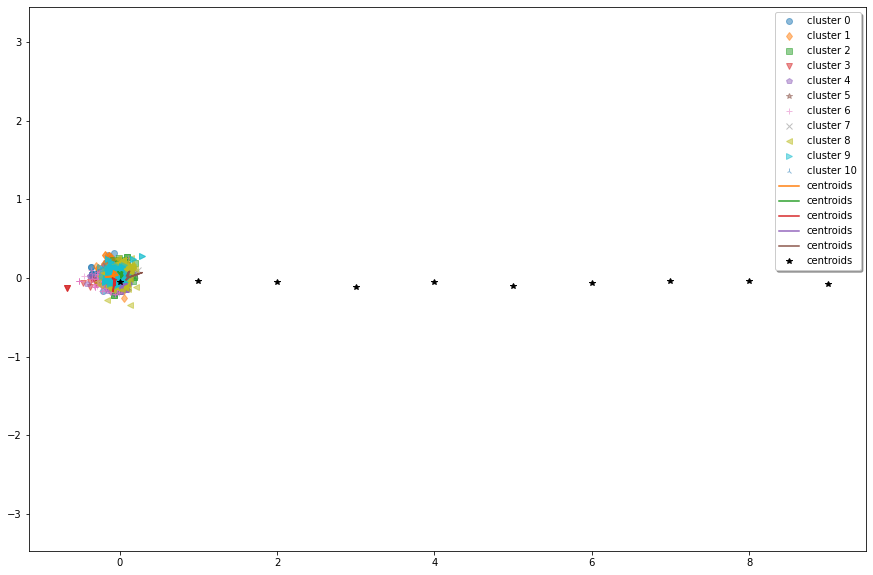

In [182]:
plt.figure(figsize=(15, 10))
w0 = x_data[label == 0]
w1 = x_data[label == 1]
w2 = x_data[label == 2]
w3 = x_data[label == 3]
w4 = x_data[label == 4]
w5 = x_data[label == 5]
w6 = x_data[label == 6]
w7 = x_data[label == 7]
w8 = x_data[label == 8]
w9 = x_data[label == 9]
w10 = x_data[label == 10]



plt.plot(w0[:, 0], w0[:, 1], 'o', alpha=0.5, label='cluster 0')
plt.plot(w1[:, 0], w1[:, 1], 'd', alpha=0.5, label='cluster 1')
plt.plot(w2[:, 0], w2[:, 1], 's', alpha=0.5, label='cluster 2')
plt.plot(w3[:, 0], w3[:, 1], 'v', alpha=0.5, label='cluster 3')
plt.plot(w4[:, 0], w4[:, 1], 'p', alpha=0.5, label='cluster 4')
plt.plot(w5[:, 0], w5[:, 1], '*', alpha=0.5, label='cluster 5')
plt.plot(w6[:, 0], w6[:, 1], '+', alpha=0.5, label='cluster 6')
plt.plot(w7[:, 0], w7[:, 1], 'x', alpha=0.5, label='cluster 7')
plt.plot(w8[:, 0], w8[:, 1], '<', alpha=0.5, label='cluster 8')
plt.plot(w9[:, 0], w9[:, 1], '>', alpha=0.5, label='cluster 9')
plt.plot(w10[:, 0], w10[:, 1], '2', alpha=0.5, label='cluster 10')



plt.plot(centroid[:, 0], centroid[:, 1], centroid[:, 2], centroid[:, 3], centroid[:, 4],
          centroid[:,5],  centroid[:, 6],  centroid[:, 7],  centroid[:, 8], 
          centroid[:, 9],  centroid[:, 10], 'k*', label='centroids')
plt.axis('equal')
plt.legend(shadow=True)
plt.show()

# Lbl2Vec

In [48]:
!pip install lbl2vec

  Using cached lbl2vec-1.0.2-py3-none-any.whl (24 kB)
Processing c:\users\yasmi\appdata\local\pip\cache\wheels\5e\6f\8c\d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe\sentence_transformers-2.2.2-py3-none-any.whl
  Using cached torch-1.13.1-cp38-cp38-win_amd64.whl (162.6 MB)
  Using cached syntok-1.4.4-py3-none-any.whl (24 kB)
  Using cached gensim-4.3.0-cp38-cp38-win_amd64.whl (24.0 MB)
  Using cached psutil-5.9.4-cp36-abi3-win_amd64.whl (252 kB)
  Using cached ray-2.3.0-cp38-cp38-win_amd64.whl (21.7 MB)
  Using cached sentencepiece-0.1.97-cp38-cp38-win_amd64.whl (1.1 MB)


ERROR: Could not install packages due to an EnvironmentError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\yasmi\\anaconda3\\Lib\\site-packages\\sentence_transformers\\losses\\ContrastiveLoss.py'
Consider using the `--user` option or check the permissions.



  Using cached FuzzyTM-2.0.5-py3-none-any.whl (29 kB)
  Using cached grpcio-1.51.3-cp38-cp38-win_amd64.whl (3.7 MB)
  Using cached virtualenv-20.20.0-py3-none-any.whl (8.7 MB)
  Using cached platformdirs-3.1.0-py3-none-any.whl (14 kB)
  Using cached distlib-0.3.6-py2.py3-none-any.whl (468 kB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
pymc3 3.8 requires arviz>=0.4.1, which is not installed.
torchvision 0.11.1 requires torch==1.10.0, but you'll have torch 1.13.1 which is incompatible.
torchaudio 0.10.0 requires torch==1.10.0, but you'll have torch 1.13.1 which is incompatible.
gensim 4.3.0 requires scipy>=1.7.0, but you'll have scipy 1.5.2 which is incompatible.
virtualenv 20.20.0 requires filelock<4,>=3.4.1, but you'll have filelock 3.0.12 which is incompatible.


  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=022f9dab463d001e51fdb7808e59c67ea52a64fd23fe14d5d838d8ec84d3bda5
  Stored in directory: c:\users\yasmi\appdata\local\pip\cache\wheels\5e\6f\8c\d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20445 sha256=1d6403b26d1eb7feb65d1218c6d1a879cf0cdfbea3c6c1f28956a0d21dd370a4
  Stored in directory: c:\users\yasmi\appdata\local\pip\cache\wheels\6a\65\c4\d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3534 sha256=3980be5df6d2209d98c66fd8f92569d0522db7ac3c8ba0dcbc9bbb9be782d71a
  Stored in directory: c:\users\yasmi\appdata\local\pip\cache\wheels\ba\d9\a0\ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built sentence-transformers fst-pso miniful
  Attempting uninstall: joblib
    Found existing installation: joblib 0

In [53]:
from lbl2vec import Lbl2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags
from sklearn.metrics import f1_score

In [61]:
# define keywords for each category
personalAccountability = ["human error", "corrective action", "group", "groups", "failure", "operator", "performance", "leadership", "delay", "delayed", "deferrals", "non-cited violations"]
questioningAttitude = ["expired", "expiring", "aging", "needing", "need", "needs", "condition", "uncertain conditions", "conditions", "equipment", "problems", "failures", "consequences"]
effectiveSafetyCommunication = ["evaluation", "review", "change", "approval", "rewinding", "replacement", "request", "challenge", "challenges", "failure", "non-cited violations"]
leadershipSafetyValuesActions = ["non-cited violations", "planning", "plan", "avoidable", "inconsistent", "guidance", "unsatisfactory", "red", "deficient", "yellow", "limit", "limited", "leaders", "not consistently", "leadership", "performance", "performance deficiencies", "not yet", "replacement", "inadequate", "adequate"]
decisionMaking = ["consequence", "poor choice", "decision-making", "decisions", "operational", "risk", "review", "assumption", "assumptions", "approach", "operation", "safe operation", "unacceptable", "uncertain conditions", "appropriate", "nuclear safety decisions"]
respectfulWorkEnvironment = ["staffing", "environment", "shift", "workers", "operator"]
continuousLearning = ["workarounds", "learning", "historical", "future", "learn", "continuous", "potential"]
problemIdentificationAndResolution = ["identify", "identified", "solution", "solutions", "problem", "problematic", "problems", "issues", "evaluation", "failure"]
environmentRaisingConcerns = ["identify", "identified", "violations", "aging", "trend", "consecutive", "health"]
workProcesses = ["procedures", "processes", "systems", "methods", "plan", "operation", "program"]

In [107]:
dictionary = {'personalAccountability':["human error, corrective action, group, groups, failure, operator, performance, leadership, delay, deferrals, non-cited violations"],
             'questioningAttitude':["expired, expiring, aging, needing, need, needs, condition, uncertain conditions, conditions, equipment, problems, failures, consequences"],
             'effectiveSafetyCommunication':["evaluation, review, change, approval, rewinding, replacement, request, challenge, challenges, failure, non-cited violations"],
             'leadershipSafetyValuesActions':["non-cited violations, planning, plan, avoidable, inconsistent, guidance, unsatisfactory, red, deficient, yellow, limit, limited, leaders, not consistently, leadership, performance, performance deficiencies, not yet, replacement, inadequate, adequate"],
             'decisionMaking':["consequence, poor choice, decision-making, decisions, operational, risk, review, assumption, assumptions, approach, operation, safe operation, unacceptable, uncertain conditions, appropriate, nuclear safety decisions"],
             'respectfulWorkEnvironment': ["staffing, environment, shift, workers, operator"],
             'continuousLearning':["workarounds, learning, historical, future, learn, continuous, potential"],
             'problemIdentificationAndResolution':["identify, identified, solution, solutions, problem, problematic, problems, issues, evaluation, failure"],
             'environmentRaisingConcerns':["identify, identified, violations, aging, trend, consecutive, health"],
              'workProcesses':["procedures, processes, systems, methods, plan, operation, program"]
             }

In [148]:
df_ = pd.DataFrame.from_dict(dictionary, orient='index')
df_
df_labels = df_.rename(columns={0:'keywords'})
df_labels

# split keywords by separator and save them as array
df_labels['keywords'] = df_labels['keywords'].apply(lambda x: x.split(','))

# convert description keywords to lowercase
df_labels['keywords'] = df_labels['keywords'].apply(lambda description_keywords: [keyword.lower() for keyword in description_keywords])

# get number of keywords for each class
df_labels['number_of_keywords'] = df_labels['keywords'].apply(lambda row: len(row))

df_labels

keywords  \
personalAccountability                                                                                                                                                [human error,  corrective action,  group,  groups,  failure,  operator,  performance,  leadership,  delay,  deferrals,  non-cited violations]   
questioningAttitude                                                                                                                                          [expired,  expiring,  aging,  needing,  need,  needs,  condition,  uncertain conditions,  conditions,  equipment,  problems,  failures,  consequences]   
effectiveSafetyCommunication                                                                                                                                                [evaluation,  review,  change,  approval,  rewinding,  replacement,  request,  challenge,  challenges,  failure,  non-cited violations]   
leadershipSafetyValuesActions       [non-cited violations,  planning,  plan,  avoidable,  inconsistent,  guidance,  unsatisfactory,  red,  deficient,  yellow,  limit,  limited,  leaders,  not consistently,  leadership,  performance,  performance deficiencies,  not yet,  replacement,  inadequate,  adequate]   
decisionMaking                                                            [consequence,  poor choice,  decision-making,  decisions,  operational,  risk,  review,  assumption,  assumptions,  approach,  operation,  safe operation,  unacceptable,  uncertain conditions,  appropriate,  nuclear safety decisions]   
respectfulWorkEnvironment                                                                                                                                                                                                                                     [staffing,  environment,  shift,  workers,  operator]   
continuousLearning                                                                                                                                                                                                                  [workarounds,  learning,  historical,  future,  learn,  continuous,  potential]   
problemIdentificationAndResolution                                                                                                                                                                [identify,  identified,  solution,  solutions,  problem,  problematic,  problems,  issues,  evaluation,  failure]   
environmentRaisingConcerns                                                                                                                                                                                                              [identify,  identified,  violations,  aging,  trend,  consecutive,  health]   
workProcesses                                                                                                                                                                                                                             [procedures,  processes,  systems,  methods,  plan,  operation,  program]   

                                    number_of_keywords  
personalAccountability                              11  
questioningAttitude                                 13  
effectiveSafetyCommunication                        11  
leadershipSafetyValuesActions                       21  
decisionMaking                                      16  
respectfulWorkEnvironment                            5  
continuousLearning                                   7  
problemIdentificationAndResolution                  10  
environmentRaisingConcerns                           7  
workProcesses                                        7

In [202]:
df_labels.reset_index()
df_labels['class_name'] =  df_labels.index

keywords  \
personalAccountability                                                                                                                                                [human error,  corrective action,  group,  groups,  failure,  operator,  performance,  leadership,  delay,  deferrals,  non-cited violations]   
questioningAttitude                                                                                                                                          [expired,  expiring,  aging,  needing,  need,  needs,  condition,  uncertain conditions,  conditions,  equipment,  problems,  failures,  consequences]   
effectiveSafetyCommunication                                                                                                                                                [evaluation,  review,  change,  approval,  rewinding,  replacement,  request,  challenge,  challenges,  failure,  non-cited violations]   
leadershipSafetyValuesActions       [non-cited violations,  planning,  plan,  avoidable,  inconsistent,  guidance,  unsatisfactory,  red,  deficient,  yellow,  limit,  limited,  leaders,  not consistently,  leadership,  performance,  performance deficiencies,  not yet,  replacement,  inadequate,  adequate]   
decisionMaking                                                            [consequence,  poor choice,  decision-making,  decisions,  operational,  risk,  review,  assumption,  assumptions,  approach,  operation,  safe operation,  unacceptable,  uncertain conditions,  appropriate,  nuclear safety decisions]   
respectfulWorkEnvironment                                                                                                                                                                                                                                     [staffing,  environment,  shift,  workers,  operator]   
continuousLearning                                                                                                                                                                                                                  [workarounds,  learning,  historical,  future,  learn,  continuous,  potential]   
problemIdentificationAndResolution                                                                                                                                                                [identify,  identified,  solution,  solutions,  problem,  problematic,  problems,  issues,  evaluation,  failure]   
environmentRaisingConcerns                                                                                                                                                                                                              [identify,  identified,  violations,  aging,  trend,  consecutive,  health]   
workProcesses                                                                                                                                                                                                                             [procedures,  processes,  systems,  methods,  plan,  operation,  program]   

                                    number_of_keywords  \
personalAccountability                              11   
questioningAttitude                                 13   
effectiveSafetyCommunication                        11   
leadershipSafetyValuesActions                       21   
decisionMaking                                      16   
respectfulWorkEnvironment                            5   
continuousLearning                                   7   
problemIdentificationAndResolution                  10   
environmentRaisingConcerns                           7   
workProcesses                                        7   

                                                            class_name  
personalAccountability                          personalAccountability  
questioningAttitude                                questioningAttitude  
effectiveSafetyComm

In [209]:
df_labels = df_labels.reset_index()
df_labels['class_index'] =  df_labels.index

In [210]:
df_labels

index  \
0              personalAccountability   
1                 questioningAttitude   
2        effectiveSafetyCommunication   
3       leadershipSafetyValuesActions   
4                      decisionMaking   
5           respectfulWorkEnvironment   
6                  continuousLearning   
7  problemIdentificationAndResolution   
8          environmentRaisingConcerns   
9                       workProcesses   

                                                                                                                                                                                                                                                                          keywords  \
0                                                                                                                                    [human error,  corrective action,  group,  groups,  failure,  operator,  performance,  leadership,  delay,  deferrals,  non-cited violations]   
1                                                                                                                           [expired,  expiring,  aging,  needing,  need,  needs,  condition,  uncertain conditions,  conditions,  equipment,  problems,  failures,  consequences]   
2                                                                                                                                          [evaluation,  review,  change,  approval,  rewinding,  replacement,  request,  challenge,  challenges,  failure,  non-cited violations]   
3  [non-cited violations,  planning,  plan,  avoidable,  inconsistent,  guidance,  unsatisfactory,  red,  deficient,  yellow,  limit,  limited,  leaders,  not consistently,  leadership,  performance,  performance deficiencies,  not yet,  replacement,  inadequate,  adequate]   
4                                        [consequence,  poor choice,  decision-making,  decisions,  operational,  risk,  review,  assumption,  assumptions,  approach,  operation,  safe operation,  unacceptable,  uncertain conditions,  appropriate,  nuclear safety decisions]   
5                                                                                                                                                                                                                            [staffing,  environment,  shift,  workers,  operator]   
6                                                                                                                                                                                                  [workarounds,  learning,  historical,  future,  learn,  continuous,  potential]   
7                                                                                                                                                                [identify,  identified,  solution,  solutions,  problem,  problematic,  problems,  issues,  evaluation,  failure]   
8                                                                                                                                                                                                      [identify,  identified,  violations,  aging,  trend,  consecutive,  health]   
9                                                                                                                                                                                                        [procedures,  processes,  systems,  methods,  plan,  operation,  program]   

   number_of_keywords  class_index                          class_name  
0                  11            0              personalAccountability  
1                  13            1                 questioningAttitude  
2                  11            2        effectiveSafetyCommunication  
3                  21            3       leadershipSafetyValuesActions  
4                  16            4                      decisionMaking  
5                   5            5           respectfulWorkEnvironment  
6         

In [199]:
df_labels.reset_index()

index  \
0              personalAccountability   
1                 questioningAttitude   
2        effectiveSafetyCommunication   
3       leadershipSafetyValuesActions   
4                      decisionMaking   
5           respectfulWorkEnvironment   
6                  continuousLearning   
7  problemIdentificationAndResolution   
8          environmentRaisingConcerns   
9                       workProcesses   

                                                                                                                                                                                                                                                                          keywords  \
0                                                                                                                                    [human error,  corrective action,  group,  groups,  failure,  operator,  performance,  leadership,  delay,  deferrals,  non-cited violations]   
1                                                                                                                           [expired,  expiring,  aging,  needing,  need,  needs,  condition,  uncertain conditions,  conditions,  equipment,  problems,  failures,  consequences]   
2                                                                                                                                          [evaluation,  review,  change,  approval,  rewinding,  replacement,  request,  challenge,  challenges,  failure,  non-cited violations]   
3  [non-cited violations,  planning,  plan,  avoidable,  inconsistent,  guidance,  unsatisfactory,  red,  deficient,  yellow,  limit,  limited,  leaders,  not consistently,  leadership,  performance,  performance deficiencies,  not yet,  replacement,  inadequate,  adequate]   
4                                        [consequence,  poor choice,  decision-making,  decisions,  operational,  risk,  review,  assumption,  assumptions,  approach,  operation,  safe operation,  unacceptable,  uncertain conditions,  appropriate,  nuclear safety decisions]   
5                                                                                                                                                                                                                            [staffing,  environment,  shift,  workers,  operator]   
6                                                                                                                                                                                                  [workarounds,  learning,  historical,  future,  learn,  continuous,  potential]   
7                                                                                                                                                                [identify,  identified,  solution,  solutions,  problem,  problematic,  problems,  issues,  evaluation,  failure]   
8                                                                                                                                                                                                      [identify,  identified,  violations,  aging,  trend,  consecutive,  health]   
9                                                                                                                                                                                                        [procedures,  processes,  systems,  methods,  plan,  operation,  program]   

   number_of_keywords                         class_index  
0                  11              personalAccountability  
1                  13                 questioningAttitude  
2                  11        effectiveSafetyCommunication  
3                  21       leadershipSafetyValuesActions  
4                  16                      decisionMaking  
5                   5           respectfulWorkEnvironment  
6                   7                  continuousLearning  
7                  10  problemIdentificat

In [183]:
# make a dataframe of the tokenized sentences above and make the text in lower case
df_lbl = pd.DataFrame (tokenized_text, columns = ['text'])
df_lbl['text'] = df_lbl['text'].apply(lambda x:x.lower())
df_lbl.head()

text
0              developed by virtual silk®24th annual report by the diablo canyon independent safety committee, july 1, 2013 - june 30, 2014\npreface  | executive summary\nvolume 1 toc  | volume 2 toc  | pg&e response  | contact the dcisc\ndiablo canyon independent safety committee\ntwenty-fourth annual report on the safety of diablo canyon nuclear power plant\noperations\njuly 1, 2013 – june 30, 2014\npeter lam, chair\nrobert k budnitz, vice-chair\nper f. peterson, member\n24th annual report by the diablo canyon independent safety committee, july 1, 2013 - june 30, 2014\npreface  | executive summary\nvolume 1 toc  | volume 2 toc  | pg&e response  | contact the dcisc\n24th annual report , preface\nthis report covers the activities of the diablo canyon independent safety committee (dcisc)\nfor the period july 1, 2013 through june 30, 2014.
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          this is the twenty-fourth annual report of the\ndcisc.
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         the report is presented in two volumes.
3  volume i  includes a report summary and conclusions and recommendation ( executive summary ), a\nbrief introduction and history regarding the dcisc, committee activities, and documents receivedby the dcisc during the reporting period \n(section 1.0 ), dcisc public meetings ( section 2.0 ), a\nreview and evaluation of nuclear regulatory commission (nrc) assessments and issues ( section\n3.0), committee member and consultant investigation topical summaries ( section 4.0 ), dcpp\nperformance indicators monitored by the dcisc ( section 5.0 ), open items being followed by the\ncommittee ( section 6.0 ), follow-up of pacific gas and electric (pg&e) actions on previous dcisc\nrecommendations ( section 7.0 ), input to the committee by members of the public ( section 8.0 ),\nand pg&e’s response ( section 9.0 ) to recommendation in this report.
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [184]:
df_lbl['text'] = df_lbl['text'].apply(lambda body :remove_dates_titles_volume(body))
df_lbl['text'] = df_lbl['text'].apply(lambda body :contractionfunction(body))
df_lbl['text'] = df_lbl['text'].apply(lambda body :remove_non_alphabetical(body))
df_lbl['text'] = df_lbl['text'].apply(lambda review:remove_stop_words(review))
df_lbl['text'] = df_lbl['text'].apply(lambda txt :leammatize_review(txt))

In [189]:
# add doc_key column
df_lbl['doc_key'] = df_lbl.index.astype(str)

In [190]:
df_lbl.head()

text  \
0  developed virtual silkth annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc diablo canyon independent safety committee twentyfourth annual report safety diablo canyon nuclear power plant operation july june peter lam chair robert k budnitz vicechair per f peterson member th annual report diablo canyon independent safety committee july june preface executive summary volume toc volume toc pge response contact dcisc th annual report preface report cover activity diablo canyon independent safety committee dcisc period july june   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              twentyfourth annual report dcisc   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   report presented two volume   
3              volume includes report summary conclusion recommendation executive summary brief introduction history regarding dcisc committee activity document receivedby dcisc reporting period section dcisc public meeting section review evaluation nuclear regulatory commission nrc assessment issue section committee member consultant investigation topical summary section dcpp performance indicator monitored dcisc section open item followed committee section followup pacific gas electric pge action previous dcisc recommendation section input committee member public section pges response section recommendation report   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  conclusion recommendation also appear bold face type throughout main body report discussion subject involved   

  doc_key  
0       0  
1       1  
2       2  
3       3  
4       4

In [203]:
df_merged = df_lbl.merge(df_labels, left_on='class', right_on='class_index', how='left').drop(['class', 'keywords'], axis=1)

TypeError: Cannot cast Index to dtype int32

In [54]:
# load train data
ag_train = pd.read_csv('train.csv',sep=',',header=None, names=['class','title','description'])

# load test data
ag_test = pd.read_csv('test.csv',sep=',',header=None, names=['class','title','description'])


In [55]:
ag_train.head()

class  \
0      3   
1      3   
2      3   
3      3   
4      3   

                                                                       title  \
0                          Wall St. Bears Claw Back Into the Black (Reuters)   
1                        Carlyle Looks Toward Commercial Aerospace (Reuters)   
2                            Oil and Economy Cloud Stocks' Outlook (Reuters)   
3               Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)   
4  Oil prices soar to all-time record, posing new menace to US economy (AFP)   

                                                                                                                                                                                                              description  
0                                                                                                                          Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.  
1  Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.  
2                                Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.  
3                     Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.  
4                                                        AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

In [44]:
all_sentences = []
with pdfplumber.open(r'DCISC-24th-Annual-Report.pdf') as pdf:
    page_numbers = len(pdf.pages) # list of pages is defined by pdf.pages
    for num in range(page_numbers):
        page = pdf.pages[num]
        page_text = page.extract_text()
        page_text = page_text.replace('\n'," ")
        all_sentences.append(page_text)  

In [45]:
all_sentences

['24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014 Preface | Executive Summary Volume 1 TOC | Volume 2 TOC | PG&E Response | Contact the DCISC Diablo Canyon Independent Safety Committee Twenty-fourth Annual Report on the Safety of Diablo Canyon Nuclear Power Plant Operations July 1, 2013 – June 30, 2014 Peter Lam, Chair Robert K Budnitz, Vice-Chair Per F. Peterson, Member Developed by Virtual Silk®',
 '24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014 Preface | Executive Summary Volume 1 TOC | Volume 2 TOC | PG&E Response | Contact the DCISC 24th Annual Report, Preface This report covers the activities of the Diablo Canyon Independent Safety Committee (DCISC) for the period July 1, 2013 through June 30, 2014. This is the twenty-fourth annual report of the DCISC. The report is presented in two volumes. Volume I includes a report summary and Conclusions and Recommendation (Executive Summary

In [46]:
all_sentences[0]

'24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014 Preface | Executive Summary Volume 1 TOC | Volume 2 TOC | PG&E Response | Contact the DCISC Diablo Canyon Independent Safety Committee Twenty-fourth Annual Report on the Safety of Diablo Canyon Nuclear Power Plant Operations July 1, 2013 – June 30, 2014 Peter Lam, Chair Robert K Budnitz, Vice-Chair Per F. Peterson, Member Developed by Virtual Silk®'

In [144]:
df1 = pd.DataFrame (all_sentences, columns = ['text'])
df1.head()

text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              24th Annual Report by the Diablo Canyon Independent Safety Committee, July 1, 2013 - June 30, 2014 Preface | Executive Summary Volume 1 TOC | Volume 2 TOC | PG&E Response | Contact the DCISC Diablo Canyon Independent Safety Committee Twenty-fourth Annual Report on the Safety of Diablo Canyon Nuclear Power Plant Operations July 1, 2013 – June 30, 2014 Peter Lam, Chair Robert K Budnitz, Vice-Chair Per F. Peterson, Member Developed by Virtual Silk®
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         